In [1]:
import json

# Load gen_path as jsonl
def load_jsonl(file_path):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    return data

# Load coverage_path as a json
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [2]:
from unidecode import unidecode
from nltk.tokenize.casual import casual_tokenize
import numpy as np

def get_ngram_coverage(text, spans, min_gram):
    try:
        tokens = casual_tokenize(unidecode(text))
    except:
        from IPython import embed; embed()
    flags = [False for _ in tokens]
    for span in spans:
        span_length = span['end_index'] - span['start_index']
        if span_length >= min_gram:
            flags[span['start_index']: span['end_index']] = [True] * span_length

    coverage = len([f for f in flags if f]) / len(flags)
    return coverage

def compute_ci_statistic(outputs, min_ngram, max_ngram, add_output_file=None, threshold=None):
    print(f'number of items {len(outputs)}')

    avg_coverages, avg_std = [], []
    ngram_list = list(range(min_ngram, max_ngram + 1))
    for output in outputs:
        coverages = []
        for min_ngram in ngram_list:
            coverage = get_ngram_coverage(output['text'], output['matched_spans'], min_ngram)
            coverages.append(coverage)

        avg_coverages.append(np.sum(coverages))
        avg_std.append(np.std(coverages))

        # print(f'percentage of tokens with a matched {min_ngram}-grams: {np.average(coverages):.3f}, std: {np.std(coverages):.3f}')
        #print(f'percentage of tokens outside of a matched {min_ngram}-grams: {1- np.average(coverages):.3f}, std: {np.std(coverages):.3f}')
    # auc, curvature = sum(avg_coverages), get_curvature(avg_coverages)
    # return auc, curvature

    return avg_coverages


In [3]:
prompt_idx = 5
start_sent = 1
num_sent = 5
model = "gpt-3.5-turbo-0125"
model = "gpt-4o-mini-2024-07-18"

if "gpt-3.5-turbo" in model:
    model_name = "ChatGPT"
else:
    model_name = "GPT-4o-mini"


# Open the jsonl
gen_path = f"/gscratch/xlab/hallisky/membership-inference/tasks/bookMIA/generations/{model}_maxTokens512_numSeq10_topP0.95_numSent{num_sent}_startSent{start_sent}_promptIdx{prompt_idx}_len100.jsonl"

min_ngram=4
all_docs = True
doc_string = "alldoc" if all_docs else "onedoc"

coverage_path = gen_path.replace(".jsonl", f"_{min_ngram}_{doc_string}.jsonl").replace("generations", "coverages")
print(coverage_path)

gen_data = load_jsonl(gen_path)
coverage_data = load_json(coverage_path)

cis = [compute_ci_statistic(cur_data, 3, 12) for cur_data in coverage_data]
covs = [[c["coverage"] for c in cur_data] for cur_data in coverage_data]

old_covs = covs.copy()
old_cis = cis.copy()

/gscratch/xlab/hallisky/membership-inference/tasks/bookMIA/coverages/gpt-4o-mini-2024-07-18_maxTokens512_numSeq10_topP0.95_numSent5_startSent1_promptIdx5_len100_4_alldoc.jsonl
number of items 10
number of items 10
number of items 10
number of items 10
number of items 9
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 6
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of items 10
number of

In [4]:
aggregate = "mean"

if aggregate == "mean":
    covs = np.array([np.mean(inner_list) for inner_list in old_covs])
    cis = np.array([np.mean(inner_list) for inner_list in old_cis])
elif aggregate == "max":
    # FISX
    covs = np.array([np.max(inner_list) for inner_list in old_covs])
    cis = np.array([np.max(inner_list) for inner_list in old_cis])

In [5]:
gen_labels = [g["label"] for g in gen_data]

FileNotFoundError: [Errno 2] No such file or directory: '/mmfs1/gscratch/xlab/hallisky/membership-inference/tasks/bookMIA/plots/GPT-4o-mini/ci_promptIdx5_minNgram4_alldoc_mean_numSent5.png'

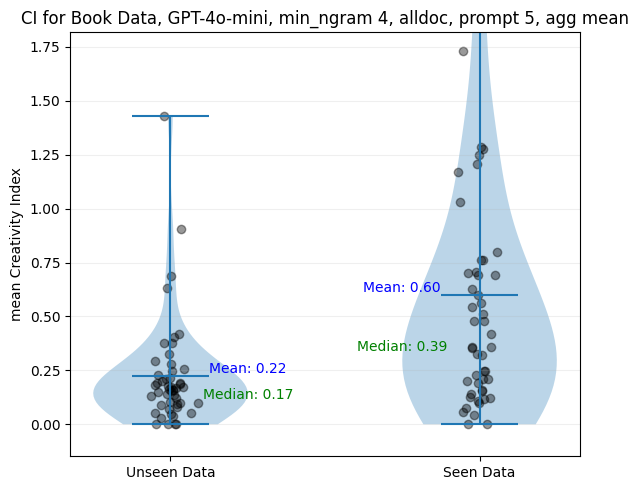

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os

data_0 = [cis[i] for i in range(len(cis)) if gen_labels[i] == 0]
data_1 = [cis[i] for i in range(len(cis)) if gen_labels[i] == 1]

# Calculate means and medians
mean_0, median_0, std0 = np.mean(data_0), np.median(data_0), np.std(data_0)
mean_1, median_1, std1 = np.mean(data_1), np.median(data_1), np.std(data_1)


# Create a violin plot with matplotlib
plt.figure(figsize=(6, 5))
plt.violinplot([data_0, data_1], showmeans=True)

# Add scatter points for each category
x_positions_0 = np.random.normal(1, 0.03, size=len(data_0))  # jitter for category 0
x_positions_1 = np.random.normal(2, 0.03, size=len(data_1))  # jitter for category 1


plt.scatter(x_positions_0, data_0, color='black', alpha=0.4)
plt.scatter(x_positions_1, data_1, color='black', alpha=0.4)

# Adding mean and median text
plt.text(1.25, mean_0, f'Mean: {mean_0:.2f}', ha='center', va='bottom', color='blue', fontsize=10)
plt.text(1.25, median_0, f'Median: {median_0:.2f}', ha='center', va='top', color='green', fontsize=10)

plt.text(1.75, mean_1, f'Mean: {mean_1:.2f}', ha='center', va='bottom', color='blue', fontsize=10)
plt.text(1.75, median_1, f'Median: {median_1:.2f}', ha='center', va='top', color='green', fontsize=10)


# Adding labels and title
plt.xticks([1, 2], ["Unseen Data", "Seen Data"])
plt.ylabel(f'{aggregate} Creativity Index')

plt.title(f'CI for Book Data, {model_name}, min_ngram {min_ngram}, {doc_string}, prompt {prompt_idx}, agg {aggregate}')
plt.ylim(top=max(mean_0 + 2*std0, mean_1 + 2*std1))
plt.grid(alpha=0.2, axis='y')
plt.tight_layout()

folder_path = "/gscratch/xlab/hallisky/membership-inference/tasks/bookMIA/plots"
plt.savefig(os.path.join(folder_path, model_name, f"ci_promptIdx{prompt_idx}_minNgram{min_ngram}_{doc_string}_{aggregate}_numSent{num_sent}.png"), dpi=200, bbox_inches="tight")


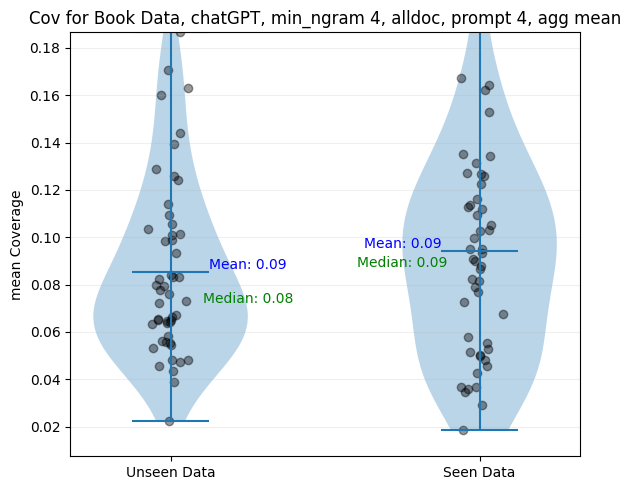

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

data_0 = [covs[i] for i in range(len(covs)) if gen_labels[i] == 0]
data_1 = [covs[i] for i in range(len(covs)) if gen_labels[i] == 1]

# Calculate means and medians
mean_0, median_0, std0 = np.mean(data_0), np.median(data_0), np.std(data_0)
mean_1, median_1, std1 = np.mean(data_1), np.median(data_1), np.std(data_1)


# Create a violin plot with matplotlib
plt.figure(figsize=(6, 5))
plt.violinplot([data_0, data_1], showmeans=True)

# Add scatter points for each category
x_positions_0 = np.random.normal(1, 0.03, size=len(data_0))  # jitter for category 0
x_positions_1 = np.random.normal(2, 0.03, size=len(data_1))  # jitter for category 1


plt.scatter(x_positions_0, data_0, color='black', alpha=0.4)
plt.scatter(x_positions_1, data_1, color='black', alpha=0.4)

# Adding mean and median text
plt.text(1.25, mean_0, f'Mean: {mean_0:.2f}', ha='center', va='bottom', color='blue', fontsize=10)
plt.text(1.25, median_0, f'Median: {median_0:.2f}', ha='center', va='top', color='green', fontsize=10)

plt.text(1.75, mean_1, f'Mean: {mean_1:.2f}', ha='center', va='bottom', color='blue', fontsize=10)
plt.text(1.75, median_1, f'Median: {median_1:.2f}', ha='center', va='top', color='green', fontsize=10)


# Adding labels and title
plt.xticks([1, 2], ["Unseen Data", "Seen Data"])
plt.ylabel(f'{aggregate} Coverage')

plt.title(f'Cov for Book Data, {model_name}, min_ngram {min_ngram}, {doc_string}, prompt {prompt_idx}, agg {aggregate}')
plt.ylim(top=max(mean_0 + 2*std0, mean_1 + 2*std1))
plt.grid(alpha=0.2, axis='y')
plt.tight_layout()

folder_path = "/gscratch/xlab/hallisky/membership-inference/tasks/bookMIA/plots"
if not os.path.exists(os.path.join(folder_path, model_name)):
    os.makedirs(os.path.join(folder_path, model_name))
plt.savefig(os.path.join(folder_path, model_name, f"cov_promptIdx{prompt_idx}_minNgram{min_ngram}_{doc_string}_{aggregate}_numSent{num_sent}.png"), dpi=200, bbox_inches="tight")
